# Finalise


In [2]:
# Saturday, 21-Jun — 5-Class with Nerissa + SMOTE
# ----------------------------------------------
# 📦 Import Required Libraries
# ----------------------------------------------
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score
)
from imblearn.over_sampling import SMOTE

# ----------------------------------------------
# 📂 Load Data
# ----------------------------------------------
train_path = "/Users/faisalmahmud/Library/CloudStorage/OneDrive-UniversityofPlymouth/PhD/Chapter/P2_reallife/DASS/FinalDataAnqi/FiveClassesDefault/FinalData/DASS_TrainData_5class.csv"
test_path = "/Users/faisalmahmud/Library/CloudStorage/OneDrive-UniversityofPlymouth/PhD/Chapter/P2_reallife/DASS/FinalDataAnqi/FiveClassesDefault/FinalData/DASS_TestData_5class.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# ----------------------------------------------
# 🔧 Configuration
# ----------------------------------------------
features = [
    'Task', 'Future', 'Past', 'Self', 'People', 'External', 'Images', 'Words',
    'Sounds', 'Detailed', 'Deliberate', 'Solution', 'Intrusive', 'Knowledge',
    'Absorption', 'Distracting', 'Meaningful'
]

target_variables = ['DASS_total_Class', 'DASS_D_Class', 'DASS_A_Class', 'DASS_S_Class']

label_map = {
    'DASS_total_Class': 'DASS Total',
    'DASS_D_Class': 'Depression',
    'DASS_A_Class': 'Anxiety',
    'DASS_S_Class': 'Stress'
}

class_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']

output_dir = "/Users/faisalmahmud/Library/CloudStorage/OneDrive-UniversityofPlymouth/PhD/Chapter/P2_reallife/DASS/FinalDataAnqi/FiveClassesDefault/ResultFinal"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------------------------
# 🚀 Train Models + Collect Results
# ----------------------------------------------
results = {}

for target_variable in target_variables:
    print(f"\n🔍 Processing target: {target_variable}")

    # Split features and labels
    X_train = df_train[features].values
    y_train = df_train[target_variable].values
    X_test = df_test[features].values
    y_test = df_test[target_variable].values

    # Show class distribution before SMOTE
    print("\n📊 Class Distribution in Training Set (Before SMOTE):")
    print(pd.Series(y_train).value_counts().sort_index().rename(index=dict(enumerate(class_names))))

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print("\n📊 Class Distribution in Training Set (After SMOTE):")
    print(pd.Series(y_train_smote).value_counts().sort_index().rename(index=dict(enumerate(class_names))))

    # Train-validation split (post-SMOTE)
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train_smote, y_train_smote, test_size=0.2, random_state=42, stratify=y_train_smote
    )

    # Grid search for best RandomForest model
    param_grid = {
        'n_estimators': [100],
        'max_depth': [30],
        'max_features': ['sqrt'],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)
    best_rf = grid_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(X_val)

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')

    print(f"\n✅ Results for {label_map[target_variable]}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))

    # SHAP values
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_val)

    # Store results
    results[target_variable] = {
        'model': best_rf,
        'X_val': X_val,
        'y_val': y_val,
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'shap_values': shap_values
    }



🔍 Processing target: DASS_total_Class

📊 Class Distribution in Training Set (Before SMOTE):
Normal              1317
Mild                 654
Moderate             830
Severe               653
Extremely Severe     596
Name: count, dtype: int64

📊 Class Distribution in Training Set (After SMOTE):
Normal              1317
Mild                1317
Moderate            1317
Severe              1317
Extremely Severe    1317
Name: count, dtype: int64

✅ Results for DASS Total
  Accuracy : 0.6591
  Precision: 0.6610
  Recall   : 0.6591

Classification Report:
                  precision    recall  f1-score   support

          Normal       0.51      0.53      0.52       264
            Mild       0.71      0.66      0.69       263
        Moderate       0.70      0.66      0.68       263
          Severe       0.70      0.71      0.70       264
Extremely Severe       0.69      0.73      0.71       263

        accuracy                           0.66      1317
       macro avg       0.66      0

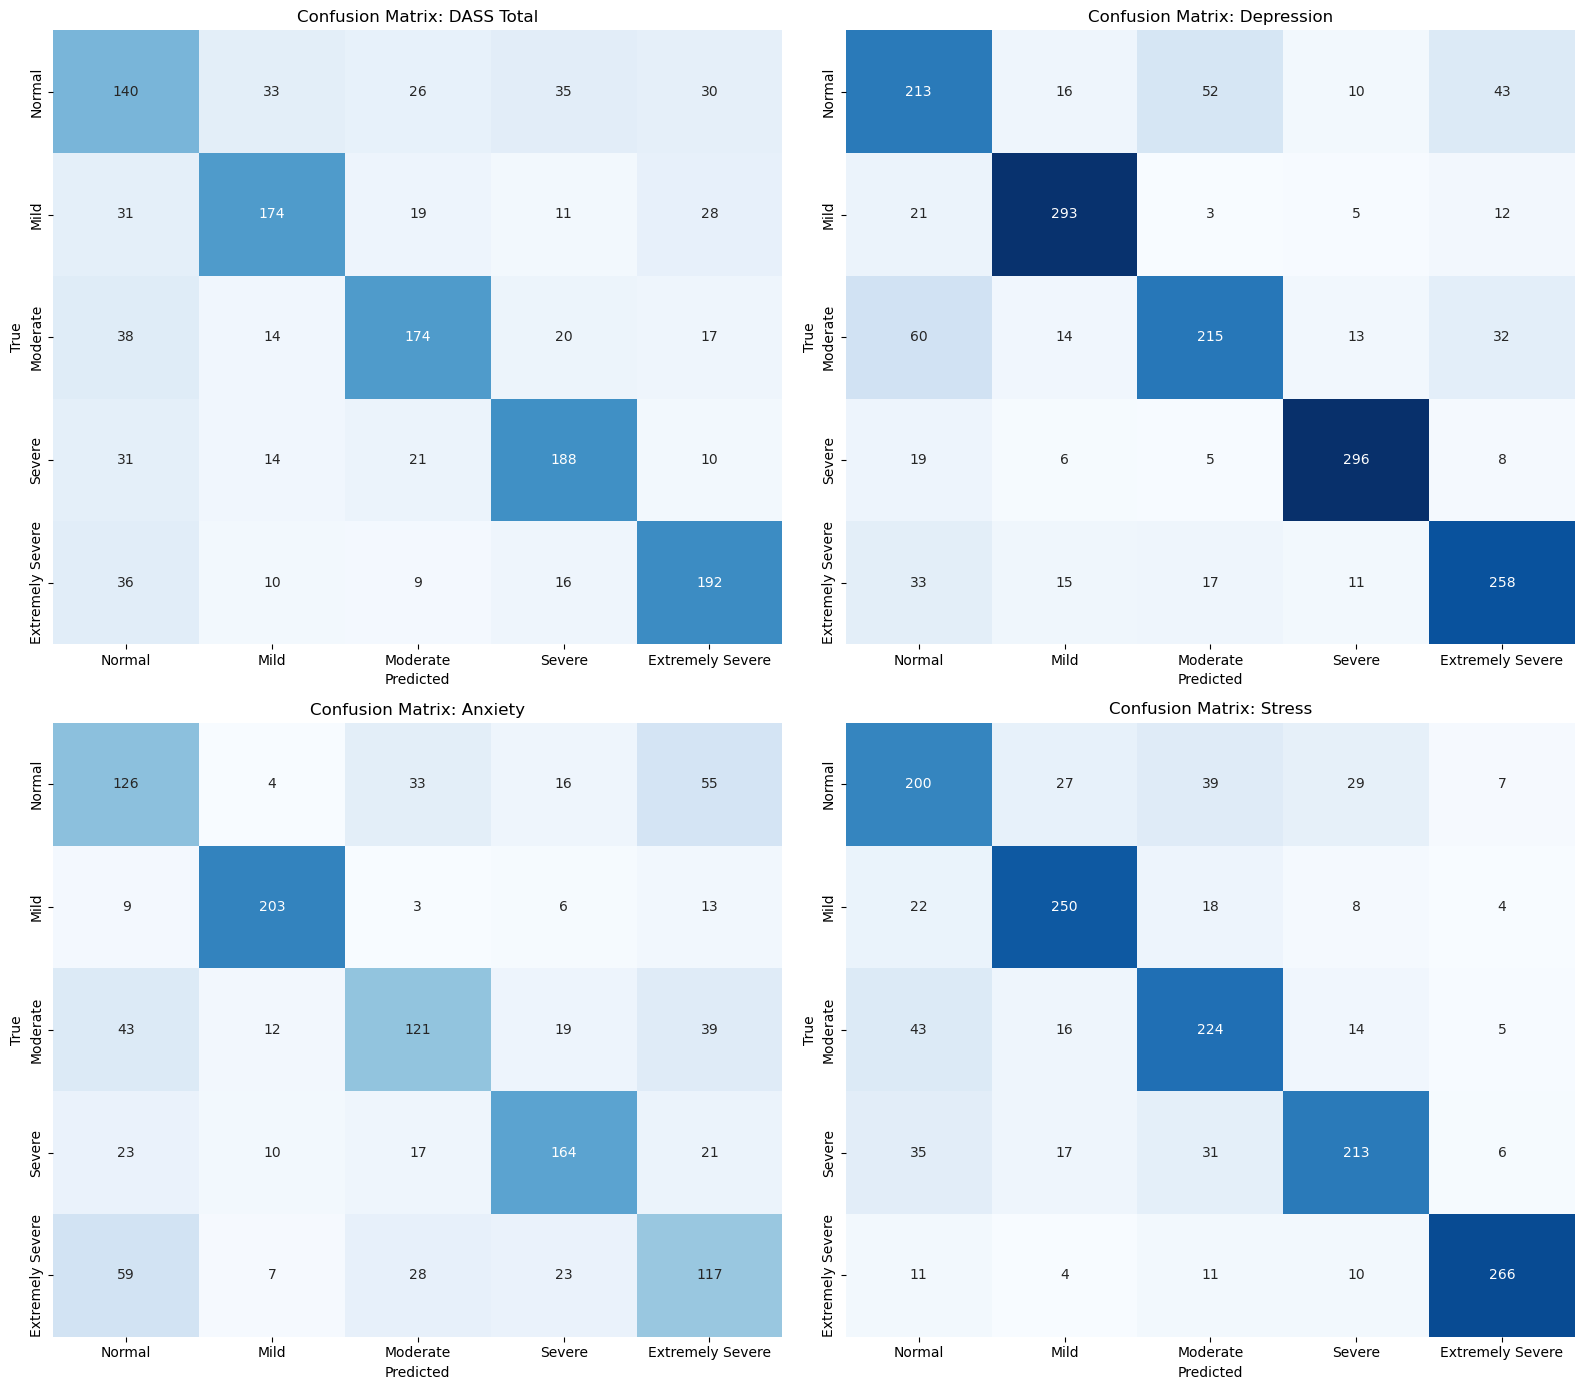

In [17]:
# ----------------------------------------------
# 📊 Plot: Combined Confusion Matrices (2x2)
# ----------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Get global min and max values across all confusion matrices
all_values = []
for target_variable in target_variables:
    cm = results[target_variable]['confusion_matrix']
    all_values.append(cm)

all_values = np.array(all_values)
vmin = all_values.min()
vmax = all_values.max()

# Step 2: Plot with shared color gradient
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for i, target_variable in enumerate(target_variables):
    cm = results[target_variable]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, ax=axes[i],
                vmin=vmin, vmax=vmax)  # 🔹 Apply unified color scale
    axes[i].set_title(f"Confusion Matrix: {label_map[target_variable]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrices_5class_Final.png"))
plt.show()


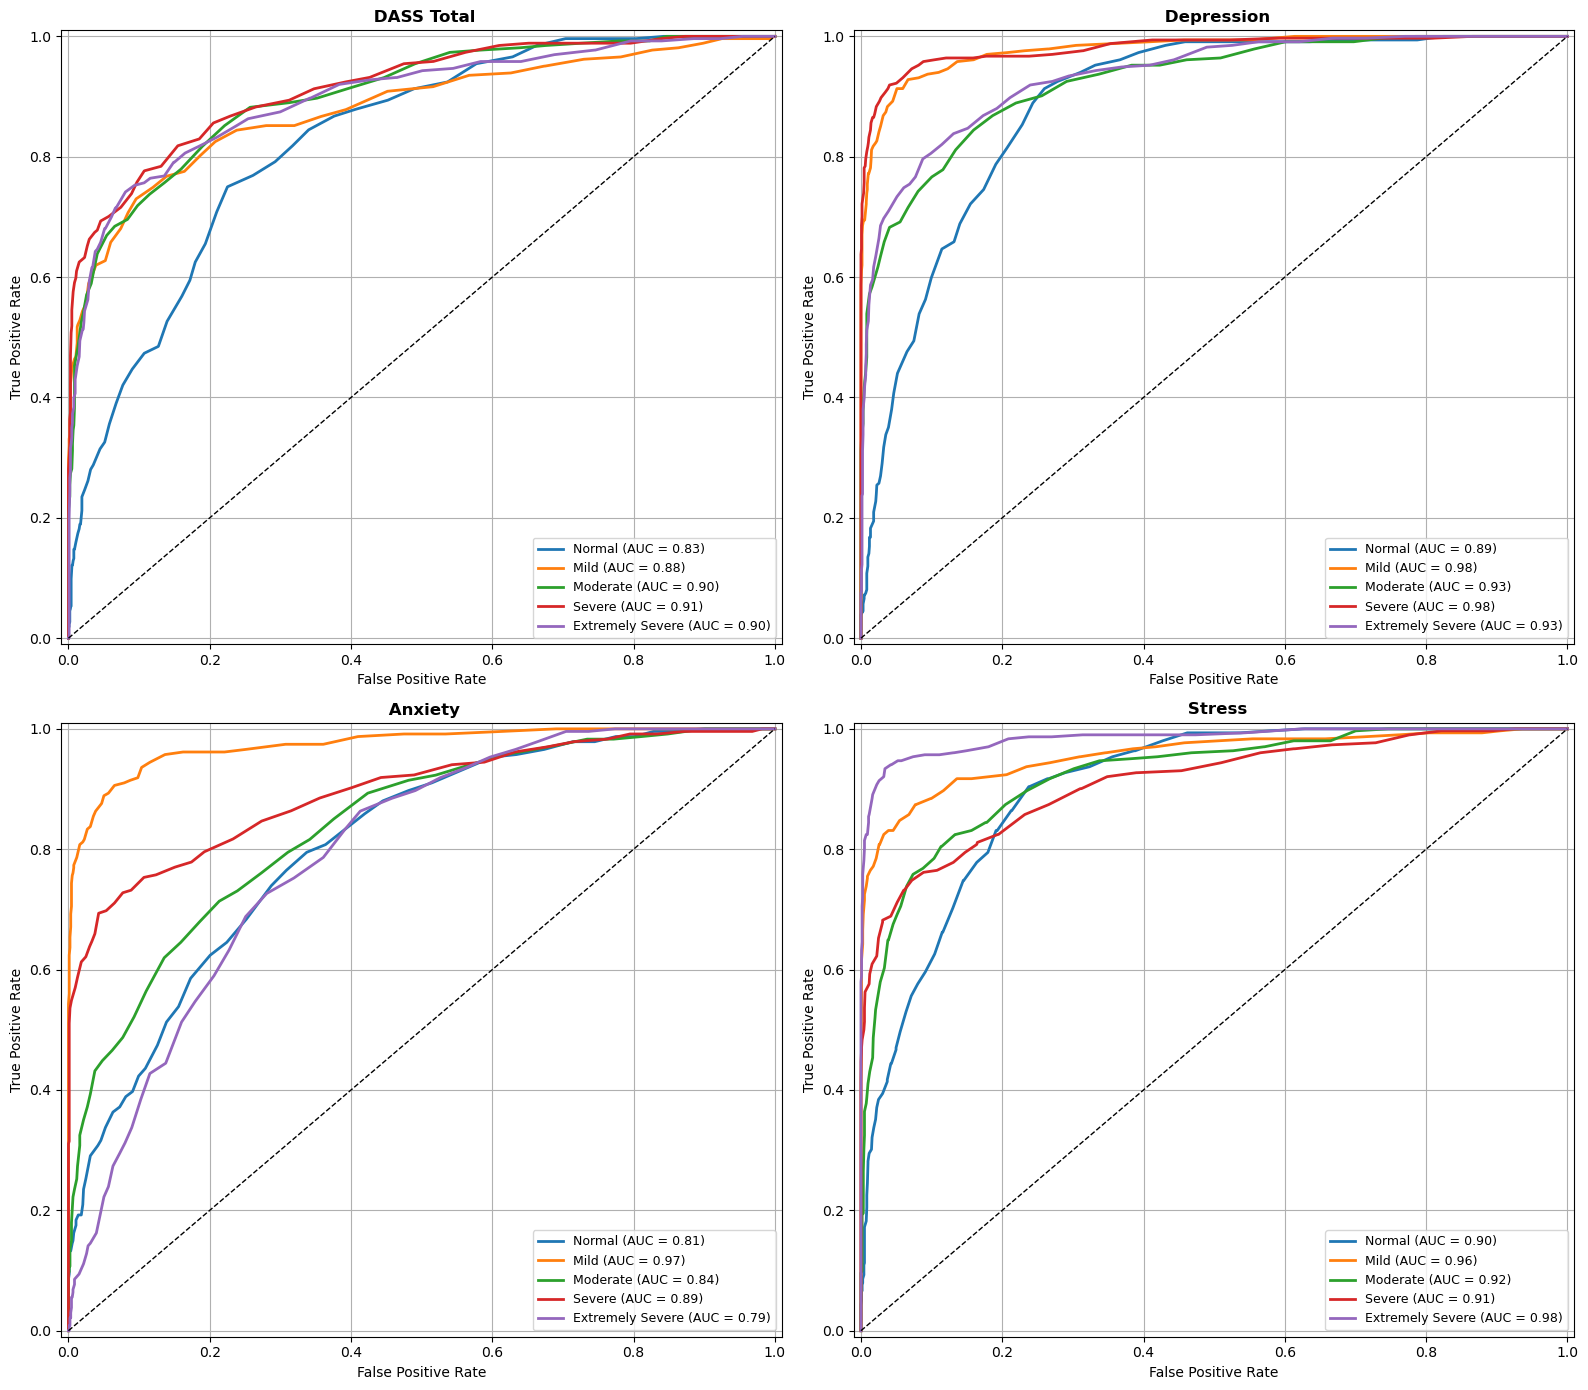

In [18]:
# ----------------------------------------------
# 📈 Combined ROC Curves (2x2) for 5-Class Targets with SMOTE
# ----------------------------------------------
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct color for each class

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, target_variable in enumerate(target_variables):
    y_val = results[target_variable]['y_val']
    model = results[target_variable]['model']
    X_val = results[target_variable]['X_val']
    
    # Binarize labels for multiclass ROC
    y_val_bin = label_binarize(y_val, classes=list(range(5)))
    y_score = model.predict_proba(X_val)

    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_score[:, i])

    ax = axes[idx]
    for i in range(len(class_names)):
        ax.plot(fpr[i], tpr[i], lw=2, color=colors[i],
                label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_title(f" {label_map[target_variable]}", fontweight='bold', color='black')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_roc_curves_2x2_globalClr.png"), dpi=300, bbox_inches='tight')
plt.show()

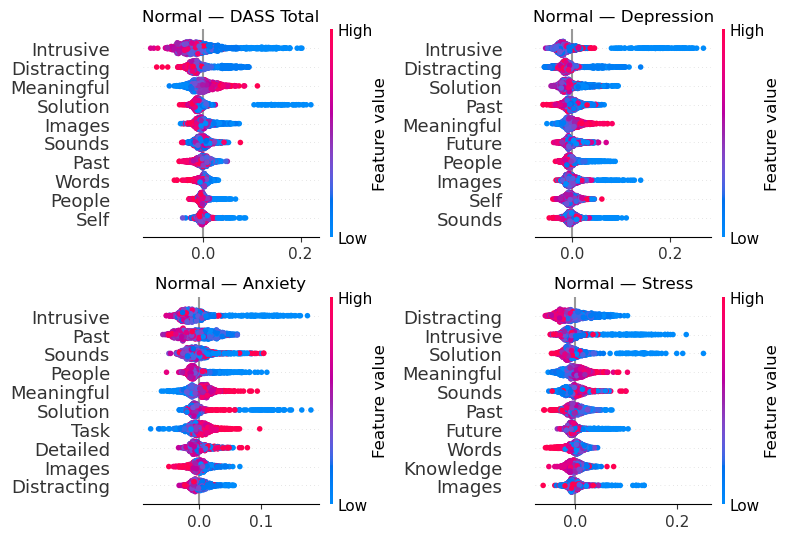

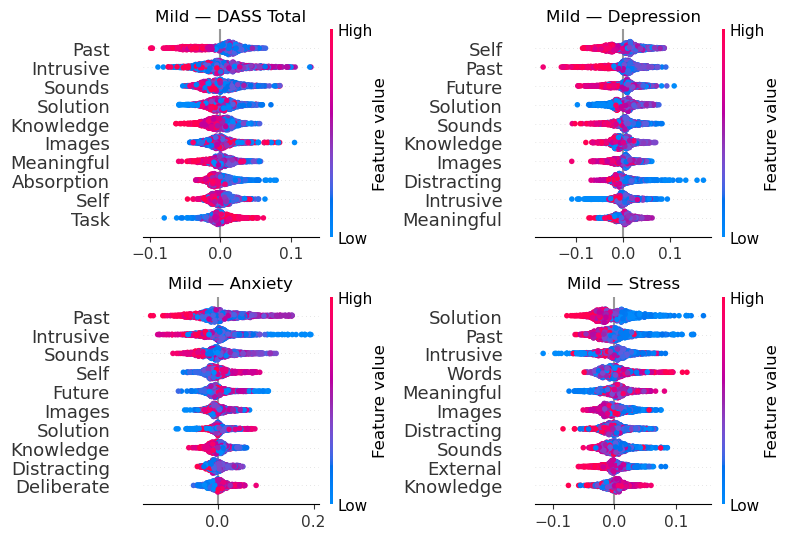

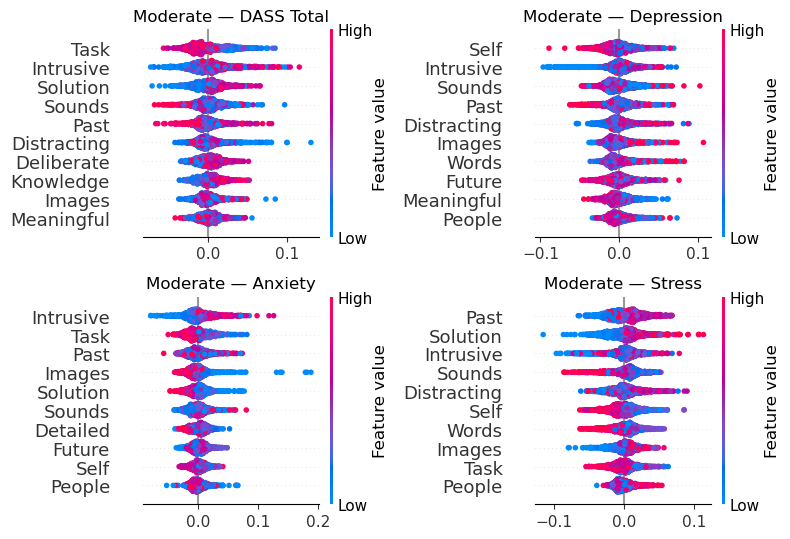

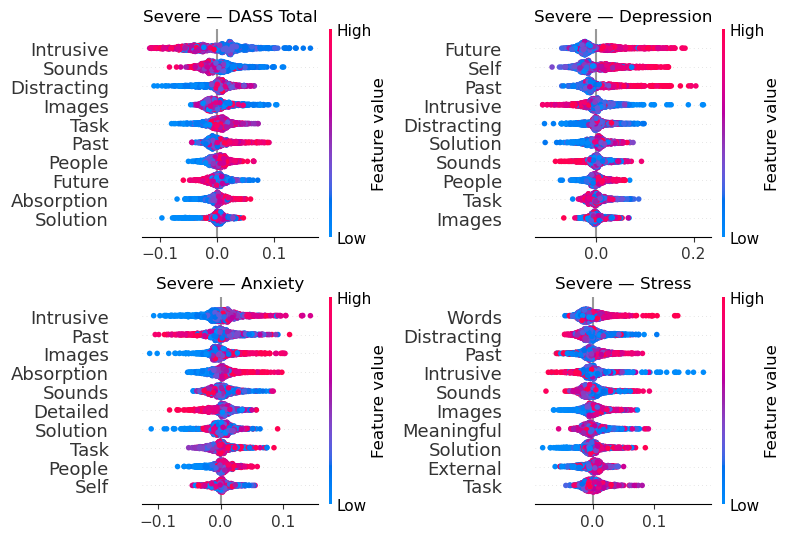

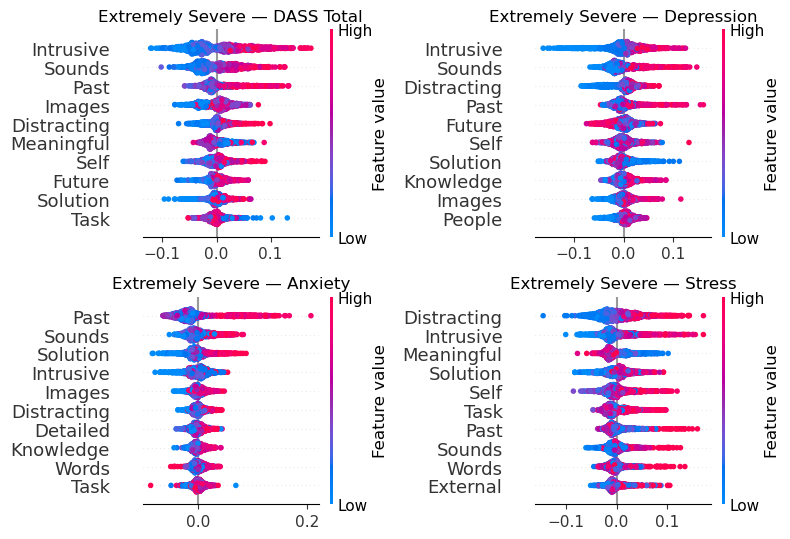

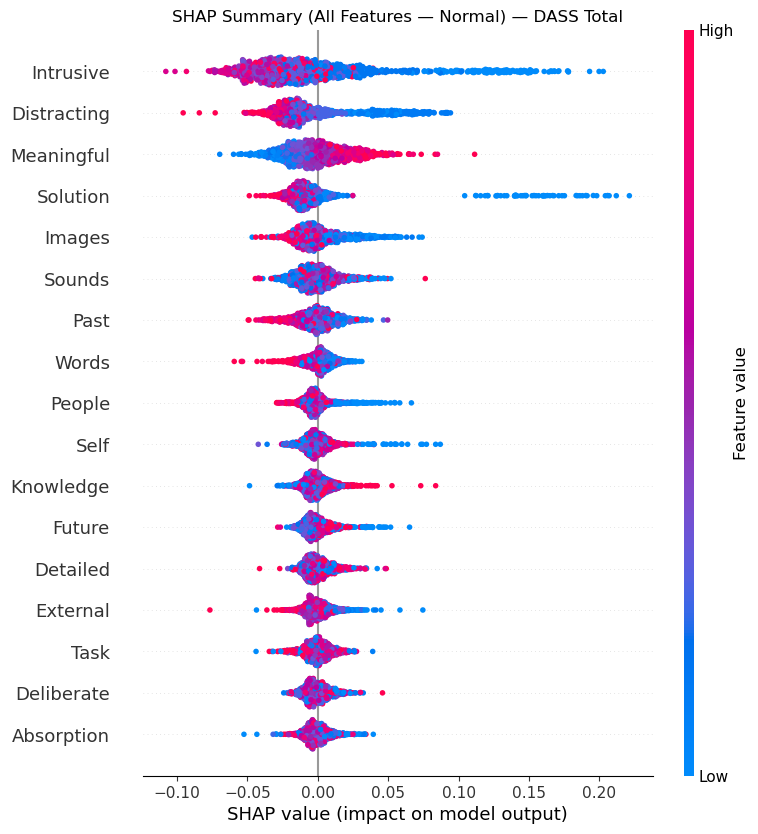

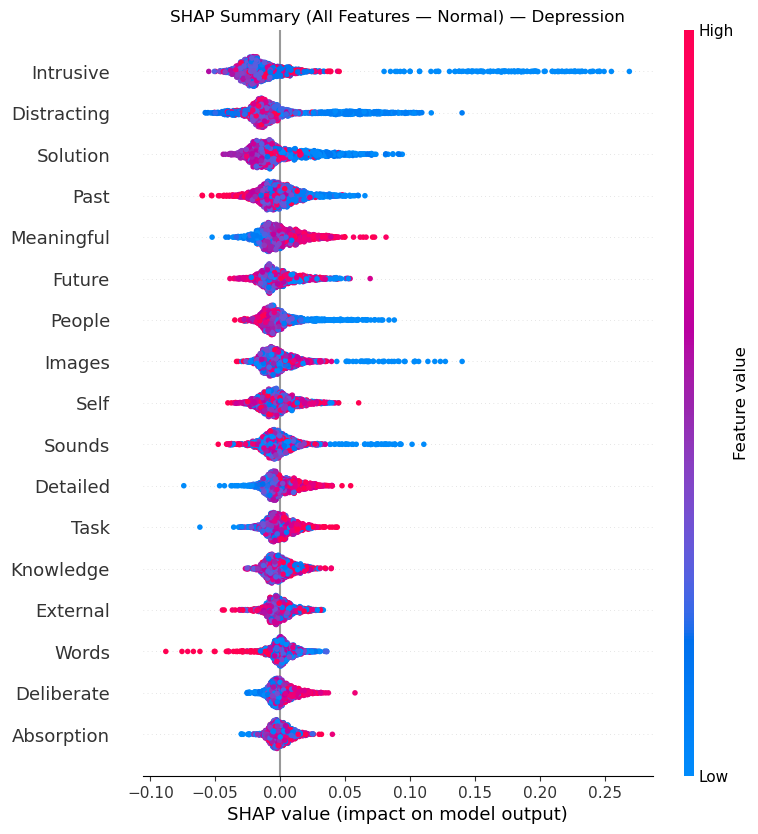

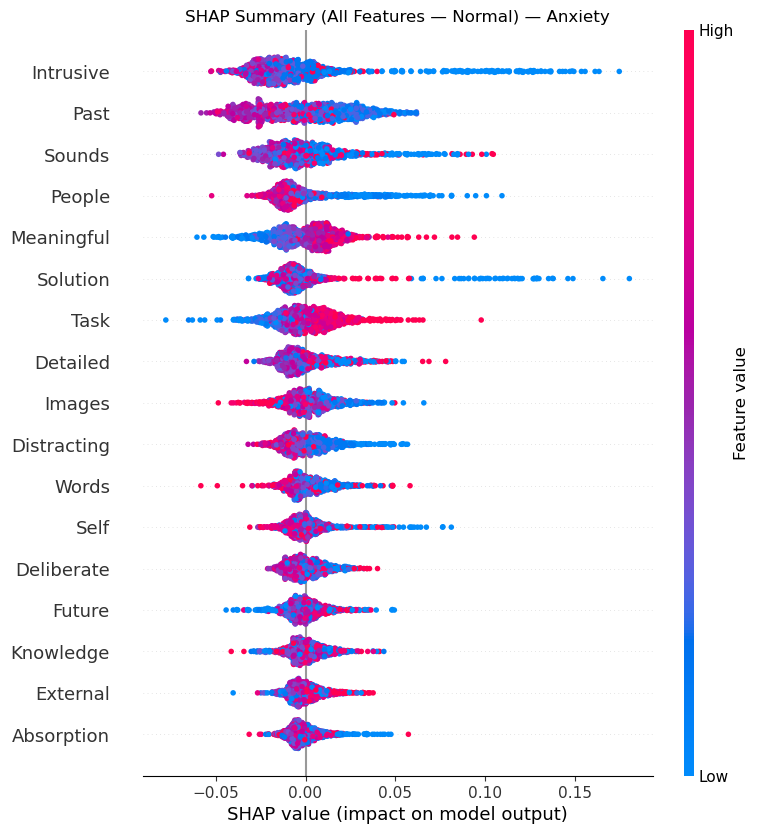

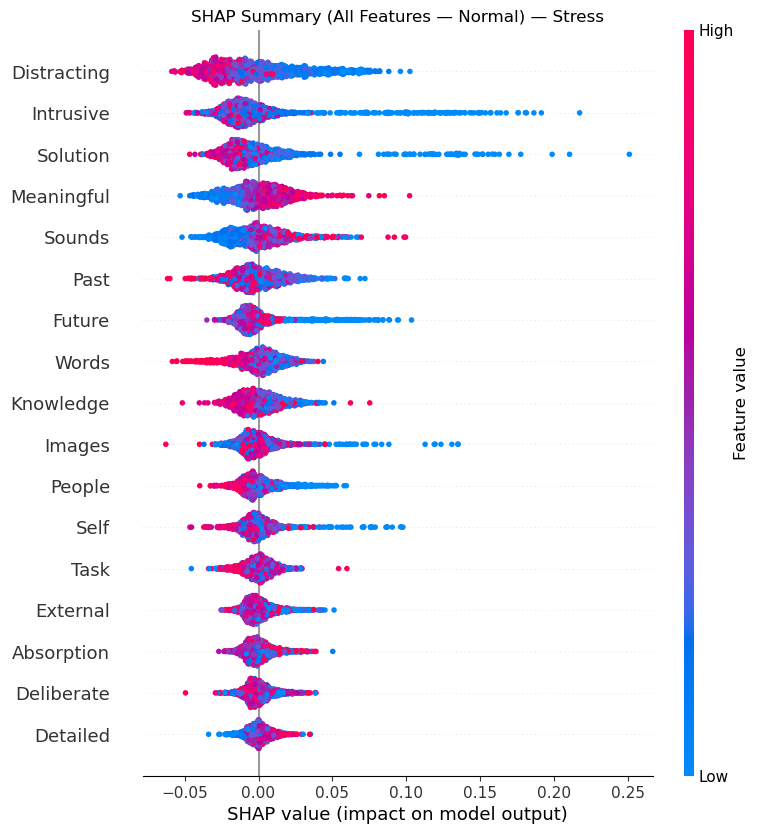

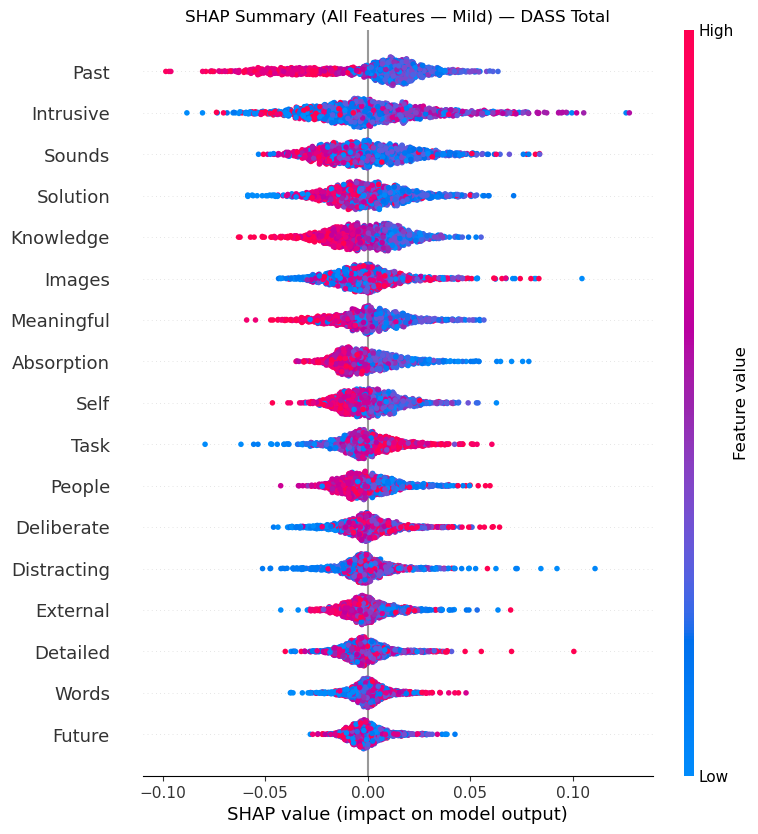

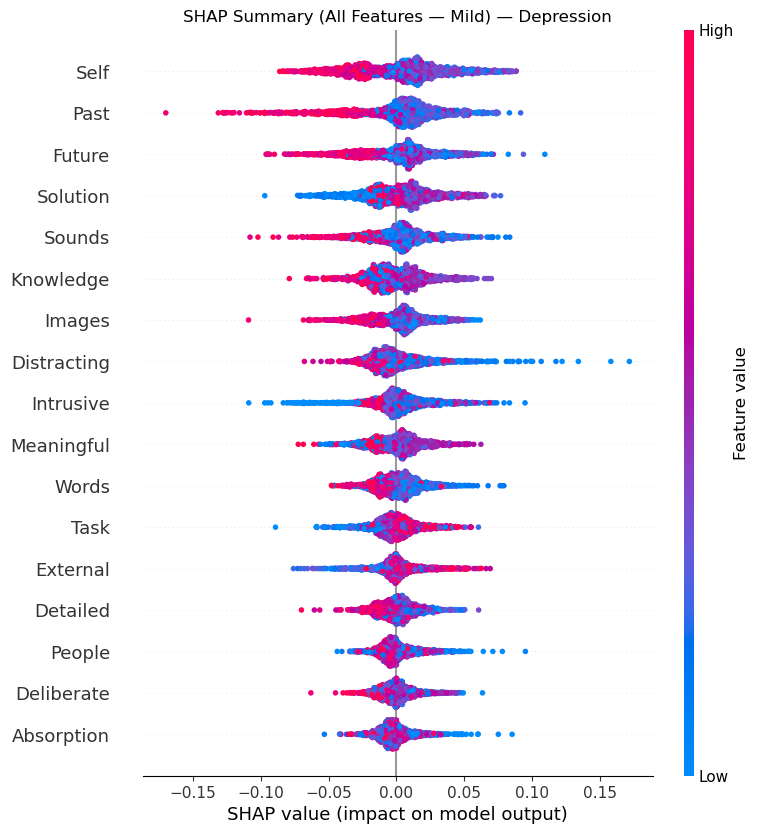

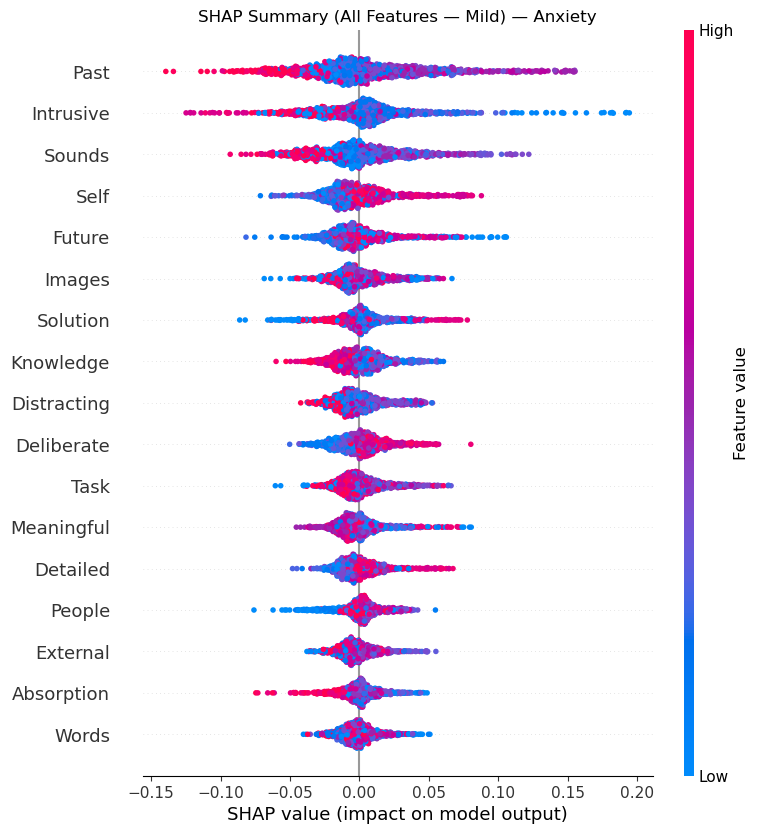

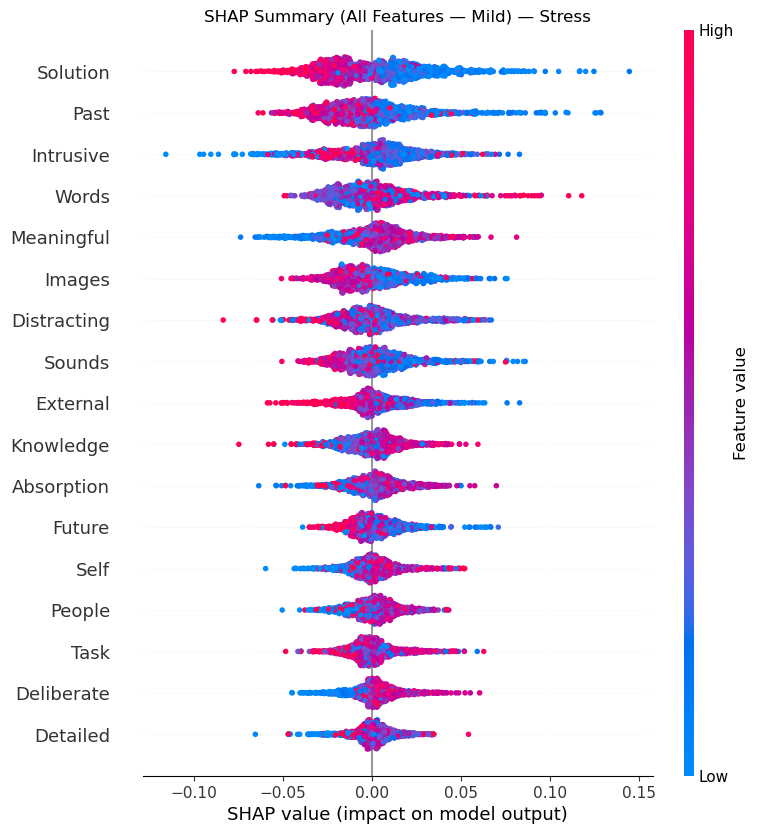

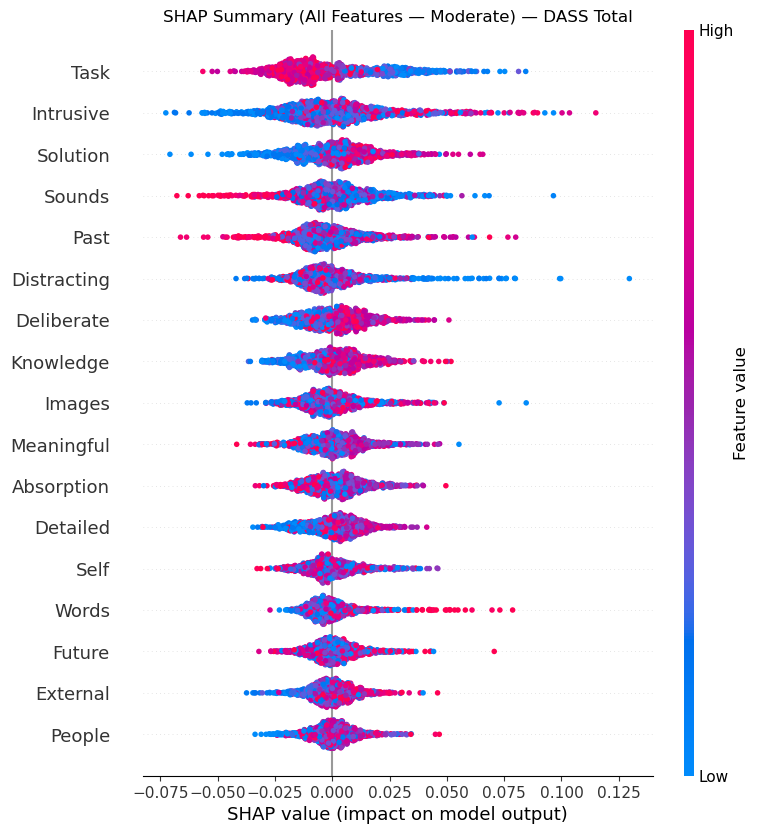

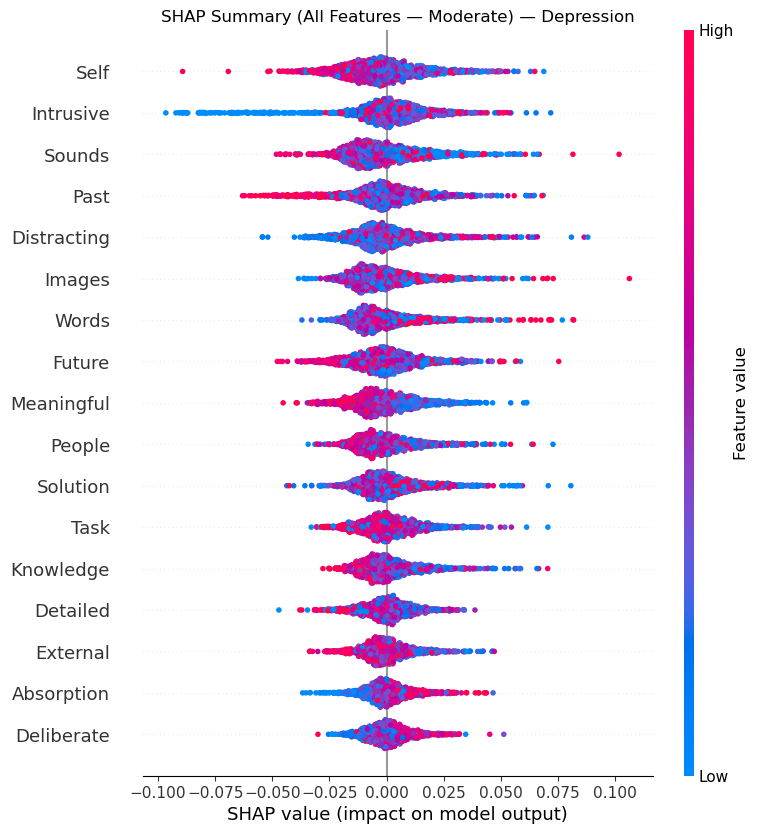

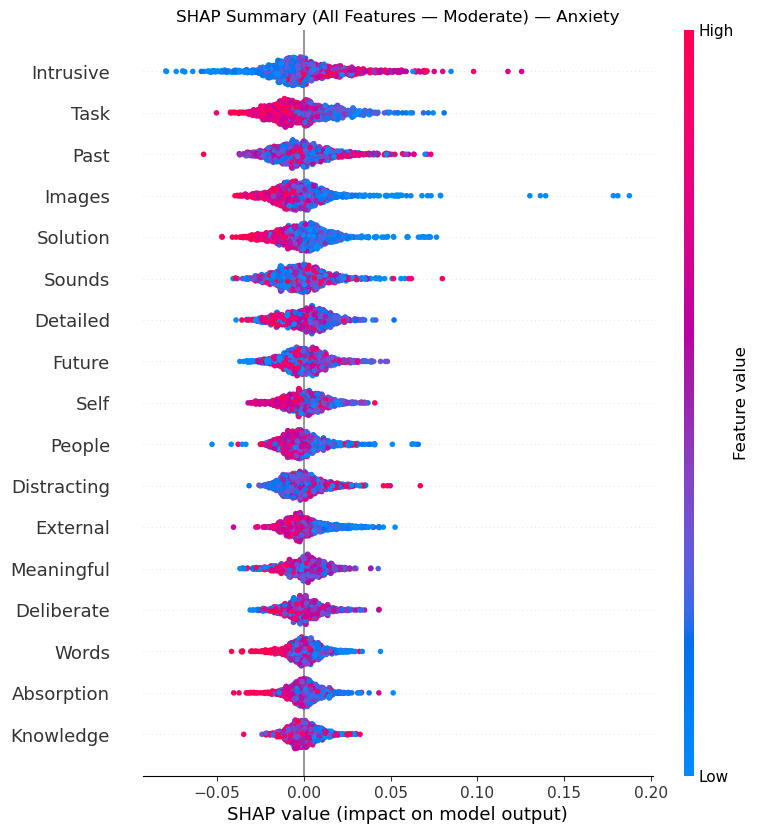

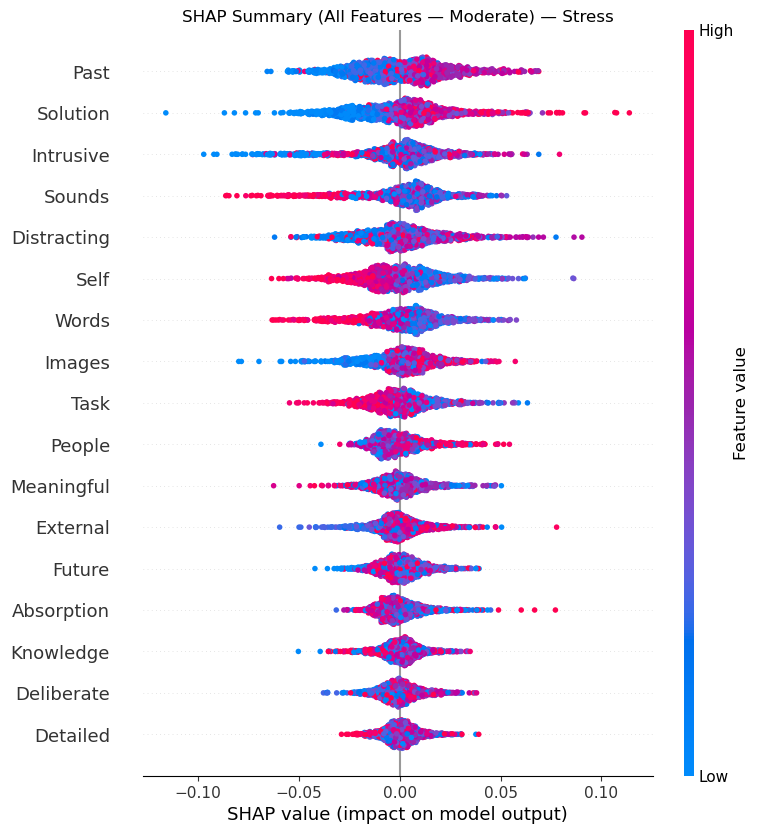

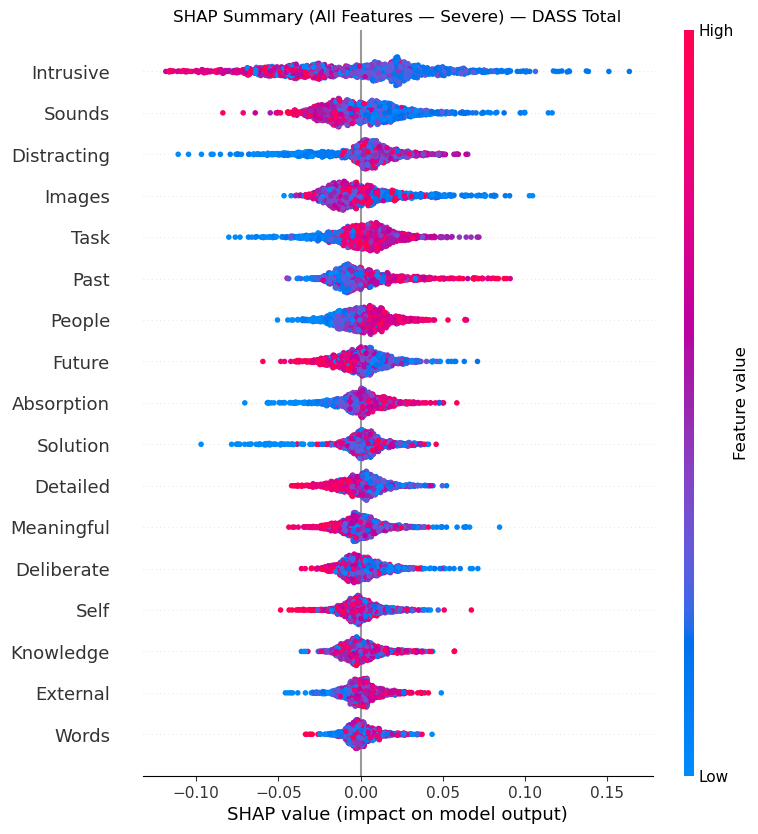

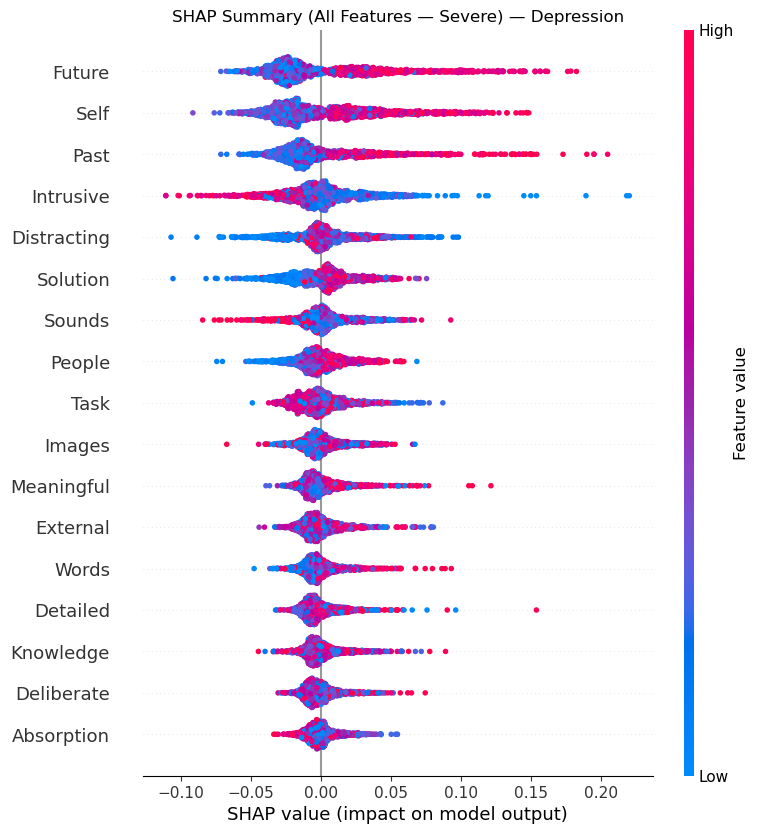

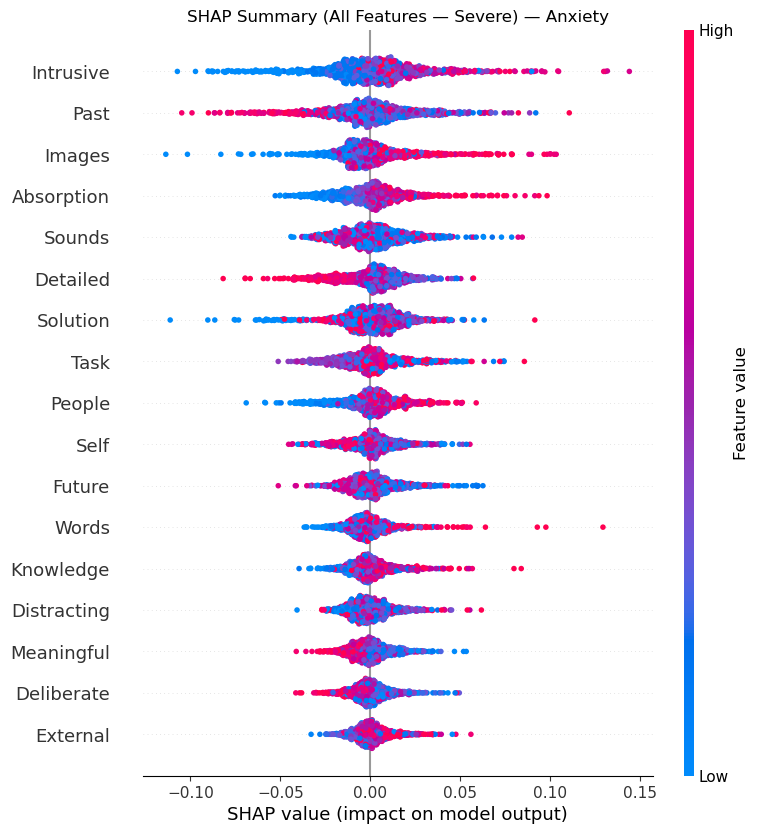

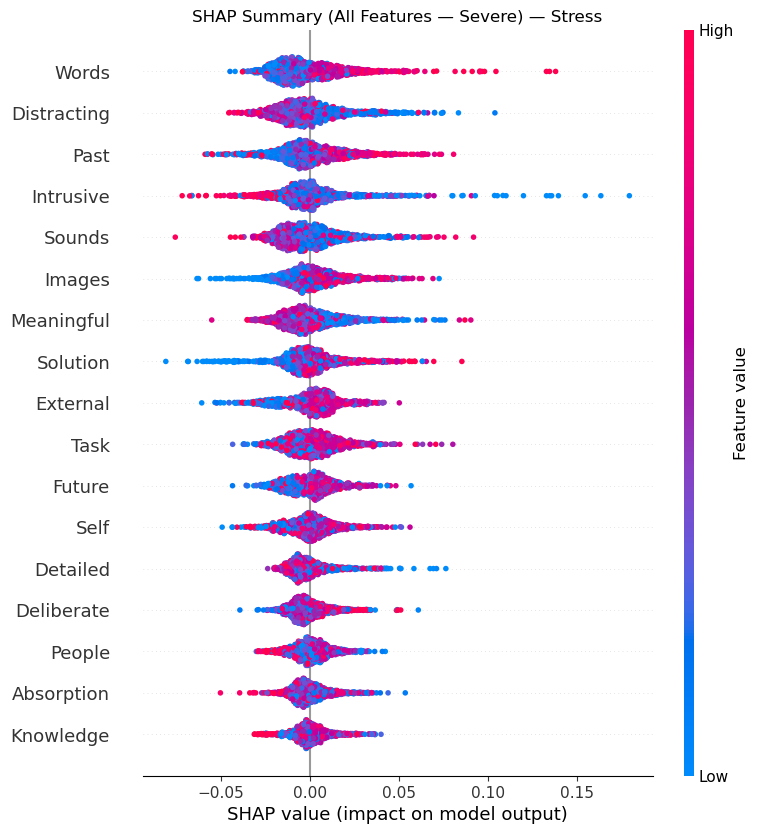

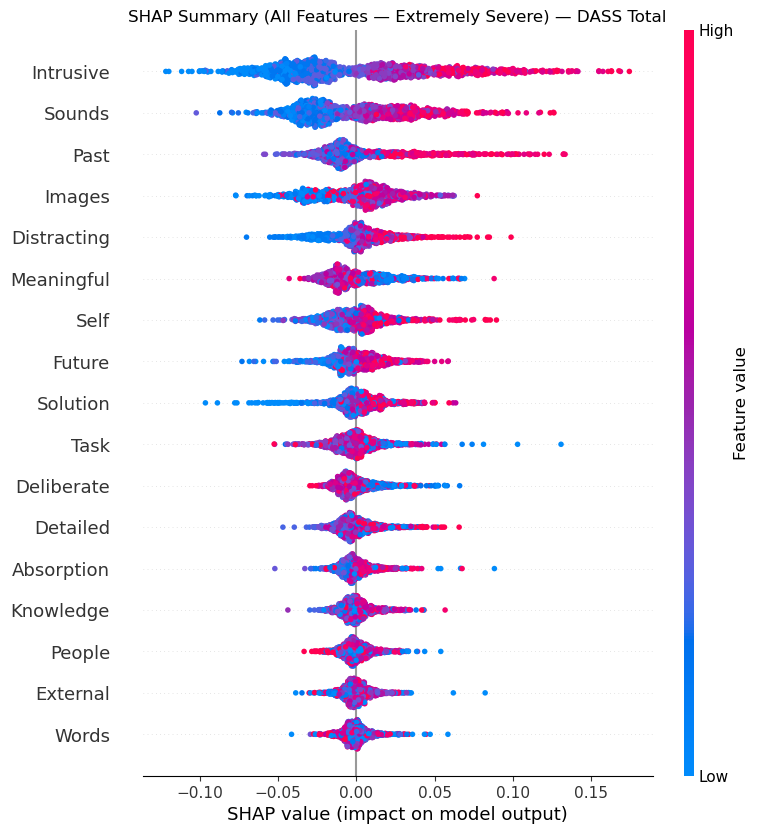

In [ ]:
# ----------------------------------------------
# 🏷️ Class Index to Severity Label Mapping
# ----------------------------------------------
severity_labels = {
    0: "Normal",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Extremely Severe"
}

# ----------------------------------------------
# 📈 SHAP Summary (Top 10 Features — 2x2 Grid per Class)
# ----------------------------------------------
for class_index in range(5):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, target_variable in enumerate(target_variables):
        shap_values = results[target_variable]['shap_values']
        X_val = results[target_variable]['X_val']

        plt.sca(axes[i])
        shap.summary_plot(
            shap_values[class_index],
            X_val,
            feature_names=features,
            show=False,
            max_display=10
        )
        axes[i].set_title(f"{severity_labels[class_index]} — {label_map[target_variable]}")
        axes[i].set_xlabel('')

    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_dir,
            f"shap_summary_top10_{severity_labels[class_index].replace(' ', '_')}_grid_Final.png"
        ),
        bbox_inches='tight'
    )
    plt.show()

# ----------------------------------------------
# 📈 SHAP Summary (All Features — Individual per Class and Target)
# ----------------------------------------------
for class_index in range(5):
    for target_variable in target_variables:
        shap_values = results[target_variable]['shap_values']
        X_val = results[target_variable]['X_val']

        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values[class_index],
            X_val,
            feature_names=features,
            show=False
        )
        plt.title(f"SHAP Summary (All Features — {severity_labels[class_index]}) — {label_map[target_variable]}")
        plt.savefig(
            os.path.join(
                output_dir,
                f"shap_summary_full_{severity_labels[class_index].replace(' ', '_')}_{target_variable}_Final.png"
            ),
            bbox_inches='tight'
        )
        plt.show()

# Comparison both